# Regularization

### Introduction

In [62]:
library(ggplot2)
library(gridExtra)
library(grid)

In [3]:
births <- read.csv('Births.csv')
head(births) 

,ï..Year,NSW,ACT,QLD,SA,WA,TAS,VIC,NT
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1977,78173,4381,35069,19086,20981,6739,59602,2923
2,1978,78190,4342,35054,18964,21094,6751,59364,2600
3,1979,77669,4217,34858,18403,20523,6947,58006,2747
4,1980,78859,4181,34666,18317,20354,6660,57768,2859
5,1981,80980,4193,37545,18960,21277,7112,58104,2749
6,1982,82185,4120,39403,19076,22236,7140,59842,3074


Create a total column

In [21]:
births[, 'Total'] <- rowSums((births[, 2:9]))
colnames(births)[1] <- "Year"

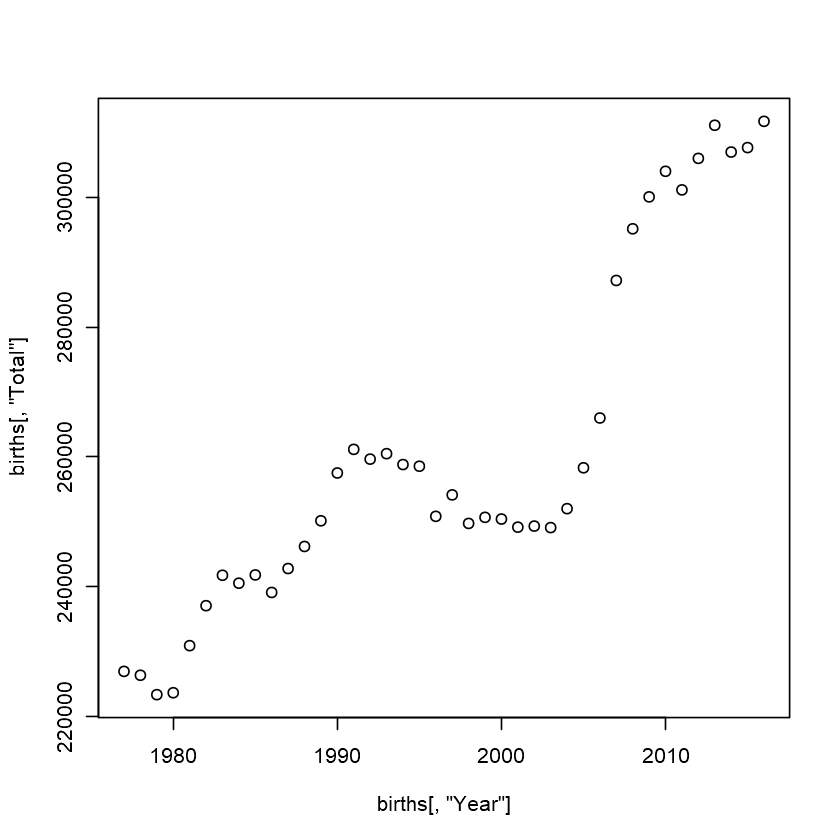

In [22]:
plot(births[, 'Year'], births[, 'Total'])

### Fitting Regressions

In [76]:
Y <- births[, 'Total']
X <- births[, 'Year']

overfit_model <- lm(Y ~ poly(X,20))
model <- lm(Y ~ poly(X,4))

A <- predict(overfit_model)
B <- predict(model)

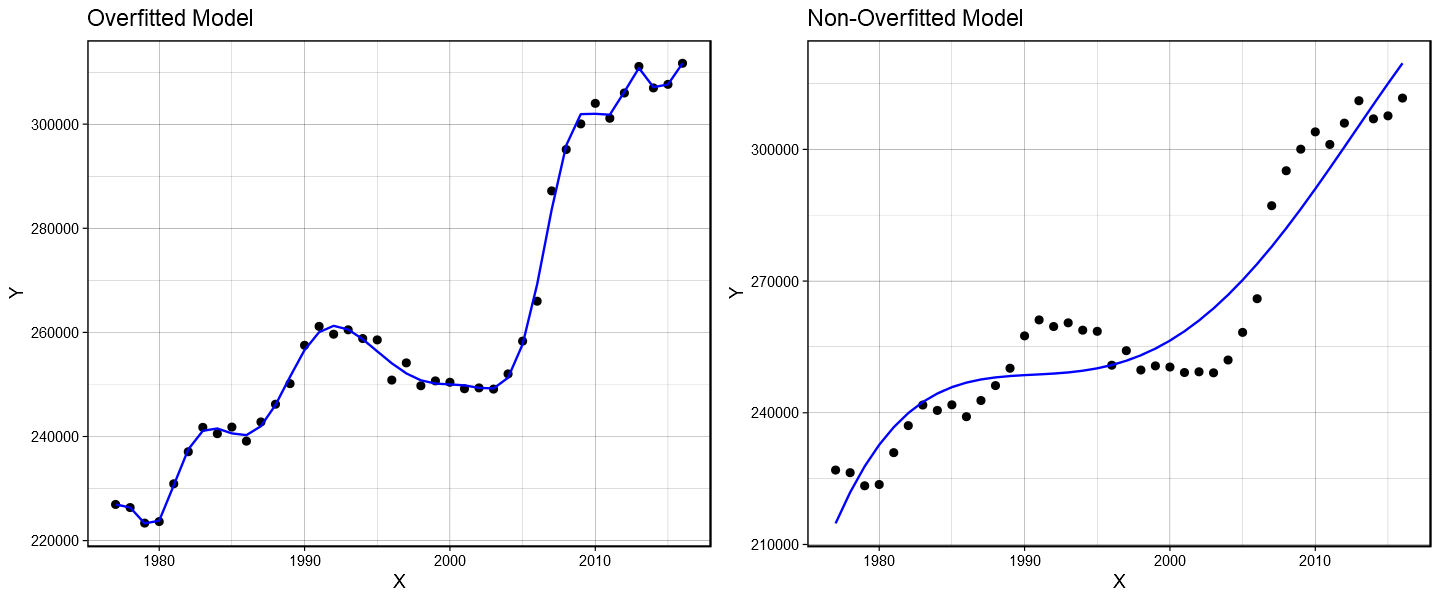

In [77]:
options(repr.plot.width=12, repr.plot.height=5) # area of display

plot1 <- ggplot(births, aes(x = X, y = Y)) + geom_point() + 
theme_linedraw() + 
ggtitle("Overfitted Model") + geom_line(color='blue', data = births, aes(x=X, y=A))

plot2 <- ggplot(births, aes(x = X, y = Y)) + geom_point() + 
theme_linedraw() + 
ggtitle("Non-Overfitted Model") +  geom_line(color='blue', data = births, aes(x=X, y=B))

grid.arrange(plot1, plot2, nrow = 1) # display of first plot